<a href="https://colab.research.google.com/github/mvgarcia/GarciaValentina_RECV_Entrega5/blob/main/GarciaValentina_RECV_Entrega5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#--- Imports
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score # Nueva métrica 

In [3]:
#-- Descomprimimos el dataset
!rm -r mnist
!unzip mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/2606.png  

In [4]:
#--- Buscamos las direcciones de cada archivo de imagen

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/0/3565.png'

In [5]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [6]:
#--- Cargamos los datos de entrenamiento en listas --- sin cruces!

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [22]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [9]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [26]:
#--- Visualizamos el tamaño de cada subset
len(X_train), len(X_valid), len(X_test)

(6000, 2000, 992)

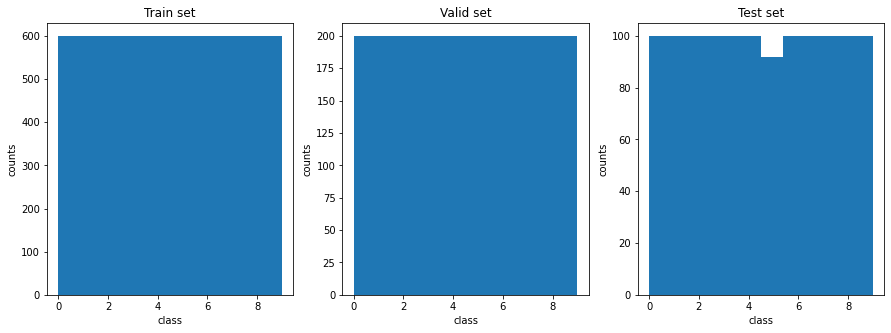

In [11]:
#--- Visualizamos la distribución de clases en cada subset

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

## Como vamos a calcular los scores varias veces definimos la función train_test que contiene todo el proceso y tiene como parámetros los arrays de los datos de entrenamiento, testeo y validación

In [42]:
def train_test(X_train_,Y_train_,X_test_,Y_test_,X_valid_,Y_valid_):
  #--- Convertimos las listas de datos a tensores de torch

  X_train_ = Variable(torch.from_numpy(np.array(X_train_))).float()
  Y_train_ = Variable(torch.from_numpy(np.array(Y_train_))).long()

  X_valid_ = Variable(torch.from_numpy(np.array(X_valid_))).float()
  Y_valid_ = Variable(torch.from_numpy(np.array(Y_valid_))).long()

  X_test_ = Variable(torch.from_numpy(np.array(X_test_))).float()
  Y_test_ = Variable(torch.from_numpy(np.array(Y_test_))).long()

  print("Size Entrenamiento: {}".format(X_train_.data.size()))
  print("Size Testeo: {}".format(X_test_.data.size()))

  #--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

  input_dim = 28*28
  out_dim = 10
  hidden = 100

  model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, out_dim)
  )

  optimizer = torch.optim.Adam(model.parameters())
  criterion = torch.nn.CrossEntropyLoss()

  #-- Número de épocas
  n_epoch = 100

  #-- Listas de evaluación entrenamiento
  loss_train = []
  f1_train = []
  acc_train = []

  #-- Listas de evaluación validación
  loss_valid = []
  f1_valid = []
  acc_valid = []

  #-- Entrenamineto de la ANN
  for epoch in range(n_epoch):
    model.train()
    
    Xtr = X_train_.view(X_train_.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_,Y_pred, average='macro') )
    
    acc = sum(Y_train_ == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

    model.eval()
    Xvl = X_valid_.view(X_valid_.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid_)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid_, Y_pred, average='macro') )

    acc = sum(Y_valid_ == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  #-- Visualizamos las curvas de entrenamiento y validación

  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.title('Loss')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.title('F1')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.title('Accuracy')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()

  plt.savefig('./curves_ok.png', bbox_inches='tight')
  plt.show()

  #-- Evaluamos el modelo entrenado con el set de testeo

  model.eval()

  Xts = X_test_.view(X_test_.size(0), -1)
  Y_pred = model(Xts)  
  loss = criterion(Y_pred,Y_test_)

  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test_, Y_pred, average='macro')

  acc = sum(Y_test_ == Y_pred)/len(Y_pred)

  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

#Cambiando entrenamiento

Realizamos un ciclo en el que tomamos los primeros 10%, 20%, 50%, 80% y 100% de los datos de entrenamiento. Esto dado que ya los revolvimos más arriba (no es necesario volverlos a escoger de manera aleatoria)

10.0% de los datos
600
600
Size Entrenamiento: torch.Size([600, 28, 28])
Size Testeo: torch.Size([992, 28, 28])


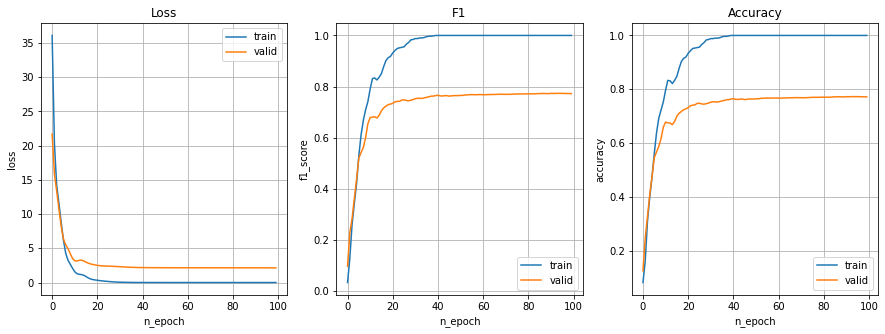

loss: 1.609166145324707, f1: 0.8209820139469143, acc: 0.8215726017951965
20.0% de los datos
1200
1200
Size Entrenamiento: torch.Size([1200, 28, 28])
Size Testeo: torch.Size([992, 28, 28])


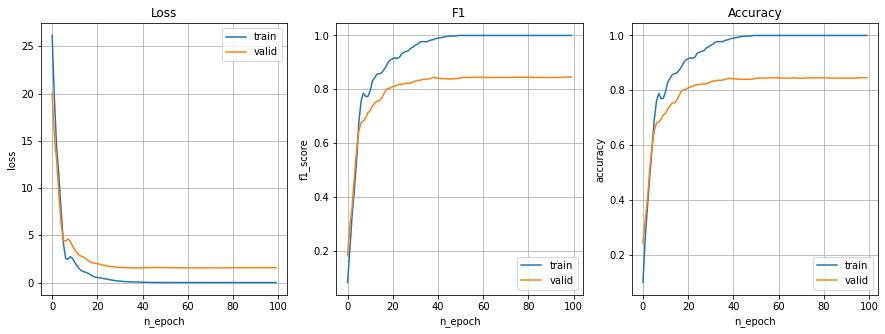

loss: 1.4343299865722656, f1: 0.8525200415517805, acc: 0.8528226017951965
50.0% de los datos
3000
3000
Size Entrenamiento: torch.Size([3000, 28, 28])
Size Testeo: torch.Size([992, 28, 28])


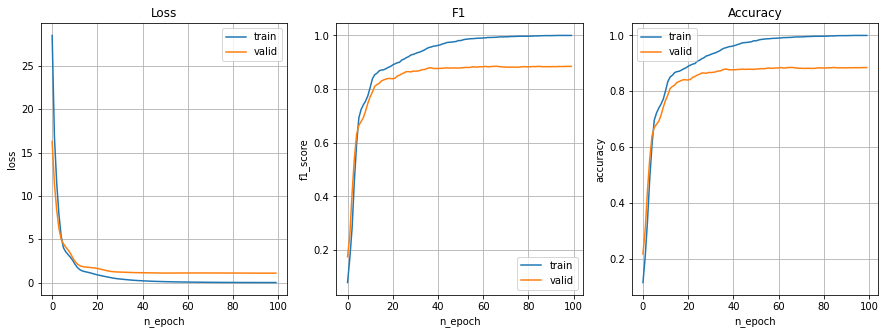

loss: 0.8963746428489685, f1: 0.9006479190829347, acc: 0.9012096524238586
80.0% de los datos
4800
4800
Size Entrenamiento: torch.Size([4800, 28, 28])
Size Testeo: torch.Size([992, 28, 28])


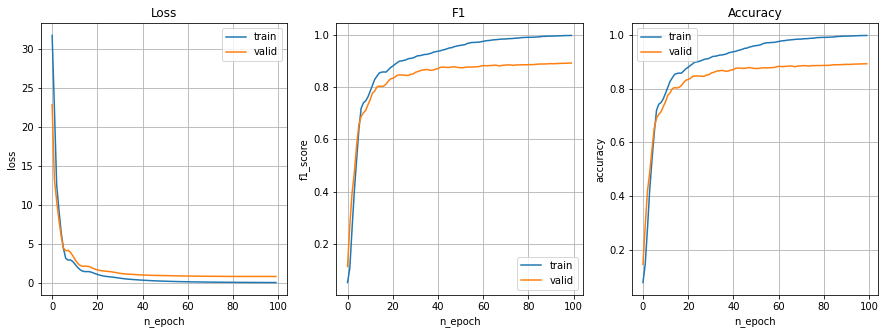

loss: 0.7303016781806946, f1: 0.9020172991069233, acc: 0.9022177457809448
100% de los datos
6000
6000
Size Entrenamiento: torch.Size([6000, 28, 28])
Size Testeo: torch.Size([992, 28, 28])


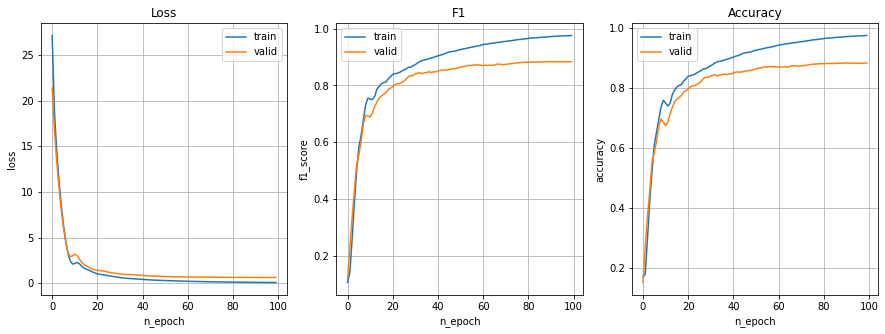

loss: 0.6515687704086304, f1: 0.8764411559862758, acc: 0.8770161271095276


In [46]:
percentages =[0.1,0.2,0.5,0.8,1]
total = len(X_train)
for percentage in percentages:
  print("{}% de los datos".format(percentage*100))
  #Hacemos una copia para no dañar la original
  X_train_copy = X_train.copy()
  X_train_copy = X_train_copy[:int(total*percentage)]
  print(len(X_train_copy))
  Y_train_copy = Y_train.copy()
  Y_train_copy = Y_train_copy[:int(total*percentage)]
  print(len(Y_train_copy))

  #Entrenamos y probamos con nuestra función
  train_test(X_train_copy,Y_train_copy,X_test,Y_test,X_valid,Y_valid)

## A medida que se van tomando diferentes porcentajes de los datos de entrenamiento para entrenar, los scores van mejorando hasta que llegan a un buen balance con loss baja y f1, acc altos.

## Las curvas de entrenamiento y validación se hacen más cercanas con el aumento en la cantidad de datos usados.

## La importancia de los datos de entrenamiento está en que entre más datos conozca el algoritmo, más perfecciona sus predicciones pues tiene más información de donde aprender. Esto se evidencia en los resultados pues, como se mencionó más arriba, al usar el 100% de los datos de entrenamiento se llega al mejor valor posible de los 3 scores.

##El score que más se ve afectado es el loss. Los valores varían mucho

#Cambiando testeo

## Hacemos lo mismo para testeo

10.0% de los datos
99
99
Size Entrenamiento: torch.Size([6000, 28, 28])
Size Testeo: torch.Size([99, 28, 28])


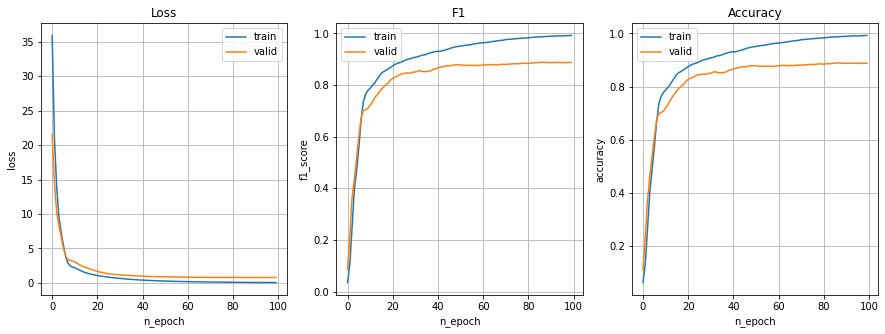

loss: 0.5229246020317078, f1: 0.9298097901759229, acc: 0.9292929172515869
20.0% de los datos
198
198
Size Entrenamiento: torch.Size([6000, 28, 28])
Size Testeo: torch.Size([198, 28, 28])


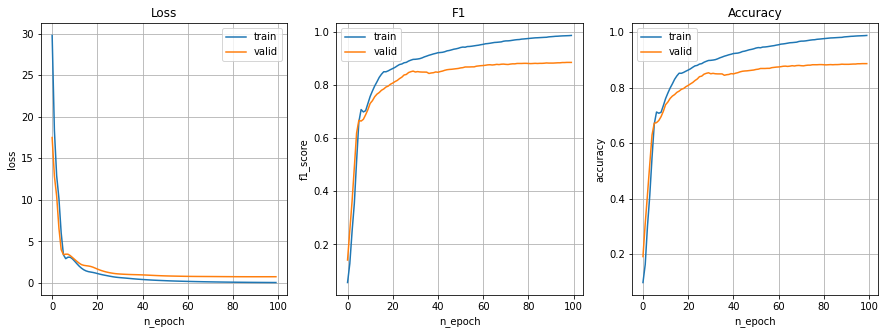

loss: 0.9944536089897156, f1: 0.893608292732365, acc: 0.8939393758773804
50.0% de los datos
496
496
Size Entrenamiento: torch.Size([6000, 28, 28])
Size Testeo: torch.Size([496, 28, 28])


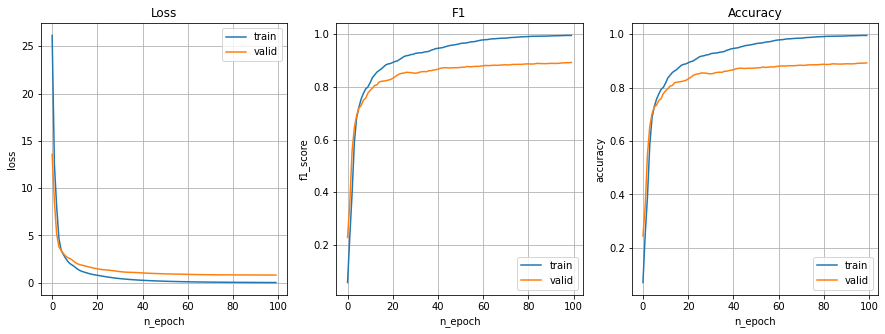

loss: 0.7054252028465271, f1: 0.8970171208147775, acc: 0.8951612710952759
80.0% de los datos
793
793
Size Entrenamiento: torch.Size([6000, 28, 28])
Size Testeo: torch.Size([793, 28, 28])


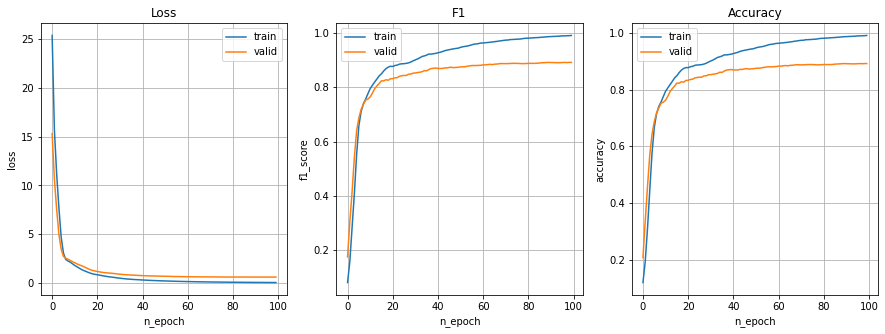

loss: 0.4917897582054138, f1: 0.8991913853253386, acc: 0.8991172909736633
100% de los datos
992
992
Size Entrenamiento: torch.Size([6000, 28, 28])
Size Testeo: torch.Size([992, 28, 28])


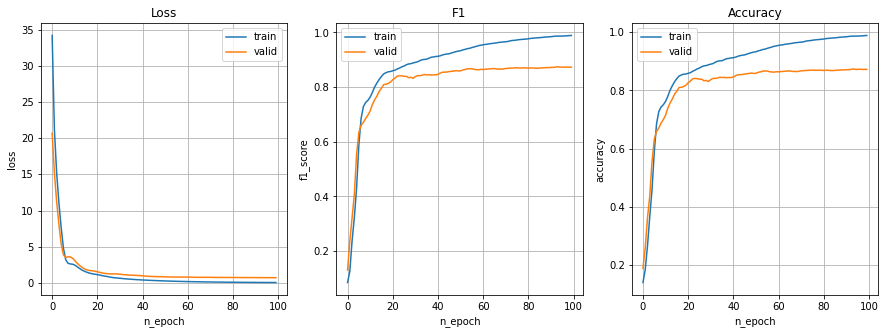

loss: 0.6655788421630859, f1: 0.9070962069233216, acc: 0.9072580933570862


In [47]:
percentages =[0.1,0.2,0.5,0.8,1]
total = len(X_test)
for percentage in percentages:
  print("{}% de los datos".format(percentage*100))
  #Hacemos una copia para no dañar la original
  X_test_copy = X_test.copy()
  X_test_copy = X_test_copy[:int(total*percentage)]
  print(len(X_test_copy))
  Y_test_copy = Y_test.copy()
  Y_test_copy = Y_test_copy[:int(total*percentage)]
  print(len(Y_test_copy))

  #Entrenamos y probamos con nuestra función
  train_test(X_train,Y_train,X_test_copy,Y_test_copy,X_valid,Y_valid)

## El tamaño del conjunto de testeo es importante dado que se debe tener un número considerable de datos con los cuales probar el algoritmo y determinar si en realidad funciona o no. Si se tienen muy poquitos, los scores obtenidos pueden no representar adecuadamente el éxito del algoritmo. Con más datos, los scores son más confiables pues se estabilizan.

## Aunque f1 y acc siempre son altos, el loss varia mucho con el porcentaje escogido hasta que llega al 100% con un loss aceptable y bajo. Podemos decir que el tamaño del conjunto de testeo afecta principalmente al loss.